# ML sur pr√©vision population

In [1]:
import numpy as np
from prophet import Prophet
import pandas as pd
import logging
import os

# Charger le jeu de donn√©es
data_folder = "datasets/datasets_destination/"
df_population_france_dep = pd.read_csv(os.path.join(data_folder, "df_population_france_dep.csv"))

# Pr√©parer le DataFrame
df_ml_population_france_dep = df_population_france_dep.copy()
df_ml_population_france_dep = df_ml_population_france_dep.drop(columns=['dimensions.SEX', 'dimensions.EP_MEASURE', 'dimensions.AGE', 'attributes.OBS_STATUS_FR', 'dimensions.GEO'])
df_ml_population_france_dep['code_dep_population'] = df_ml_population_france_dep['code_dep_population'].apply(lambda x: '201' if x == '2A' else ('202' if x == '2B' else x))
df_ml_population_france_dep['code_dep_population'] = df_ml_population_france_dep['code_dep_population'].astype(int)
df_ml_population_france_dep = df_ml_population_france_dep.sort_values(by=['code_dep_population', 'population_annee'], ascending=[True, True])

# Ajouter une feature de retard pour capturer la tendance temporelle
df_ml_population_france_dep['population_t-1'] = df_ml_population_france_dep.groupby('code_dep_population')['population'].shift(1)
df_ml_population_france_dep.dropna(inplace=True)

# Configurer le niveau de journalisation pour Prophet
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)
logging.getLogger('prophet').setLevel(logging.ERROR)

# Supposons que df_ml_population_france_dep soit votre DataFrame
results = []

# Boucle sur chaque d√©partement
for dept in df_ml_population_france_dep['code_dep_population'].unique():
    # Filtrer les donn√©es pour le d√©partement courant
    dept_data = df_ml_population_france_dep[df_ml_population_france_dep['code_dep_population'] == dept]

    # V√©rifier si des donn√©es sont pr√©sentes
    if dept_data.empty:
        continue

    # Pr√©parer les donn√©es pour Prophet
    df_prophet = dept_data[['population_annee', 'population']].rename(columns={'population_annee': 'ds', 'population': 'y'})
    df_prophet['ds'] = pd.to_datetime(df_prophet['ds'], format='%Y')

    # Initialiser et configurer le mod√®le Prophet
    model = Prophet(
        yearly_seasonality=False,
        seasonality_mode='additive',  # Essayez le mode additif
        changepoint_prior_scale=0.1,  # R√©duisez la sensibilit√© aux changements
        n_changepoints=5  # Augmentez le nombre de points de changement pour plus de flexibilit√©
    )

    model.fit(df_prophet)

    # Cr√©er un DataFrame pour les pr√©dictions futures
    future = model.make_future_dataframe(periods=1, freq='YE')

    # Faire des pr√©dictions
    forecast = model.predict(future)

    # Extraire la pr√©diction pour la derni√®re date pr√©dite
    prediction_2026 = forecast['yhat'].iloc[-1]

    # Stocker les r√©sultats avec l'ann√©e de pr√©diction
    results.append({
        'code_dep_population': dept,
        'population_annee': 2026,
        'population': prediction_2026
    })

# Convertir les r√©sultats en DataFrame
df_results_prophet = pd.DataFrame(results)

# Concat√©ner les DataFrames
df_concatenated_population = pd.concat([df_ml_population_france_dep, df_results_prophet], axis=0)
df_concatenated_population = df_concatenated_population.drop(columns=['population_t-1'])

# R√©initialiser l'index
df_concatenated_population['population'] = df_concatenated_population['population'].astype(int)
df_concatenated_population.reset_index(drop=True, inplace=True)



15:05:08 - cmdstanpy - INFO - Chain [1] start processing
15:05:08 - cmdstanpy - INFO - Chain [1] done processing
15:05:08 - cmdstanpy - INFO - Chain [1] start processing
15:05:08 - cmdstanpy - INFO - Chain [1] done processing
15:05:08 - cmdstanpy - INFO - Chain [1] start processing
15:05:08 - cmdstanpy - INFO - Chain [1] done processing
15:05:08 - cmdstanpy - INFO - Chain [1] start processing
15:05:08 - cmdstanpy - INFO - Chain [1] done processing
15:05:08 - cmdstanpy - INFO - Chain [1] start processing
15:05:08 - cmdstanpy - INFO - Chain [1] done processing
15:05:08 - cmdstanpy - INFO - Chain [1] start processing
15:05:08 - cmdstanpy - INFO - Chain [1] done processing
15:05:08 - cmdstanpy - INFO - Chain [1] start processing
15:05:08 - cmdstanpy - INFO - Chain [1] done processing
15:05:09 - cmdstanpy - INFO - Chain [1] start processing
15:05:09 - cmdstanpy - INFO - Chain [1] done processing
15:05:09 - cmdstanpy - INFO - Chain [1] start processing
15:05:09 - cmdstanpy - INFO - Chain [1]

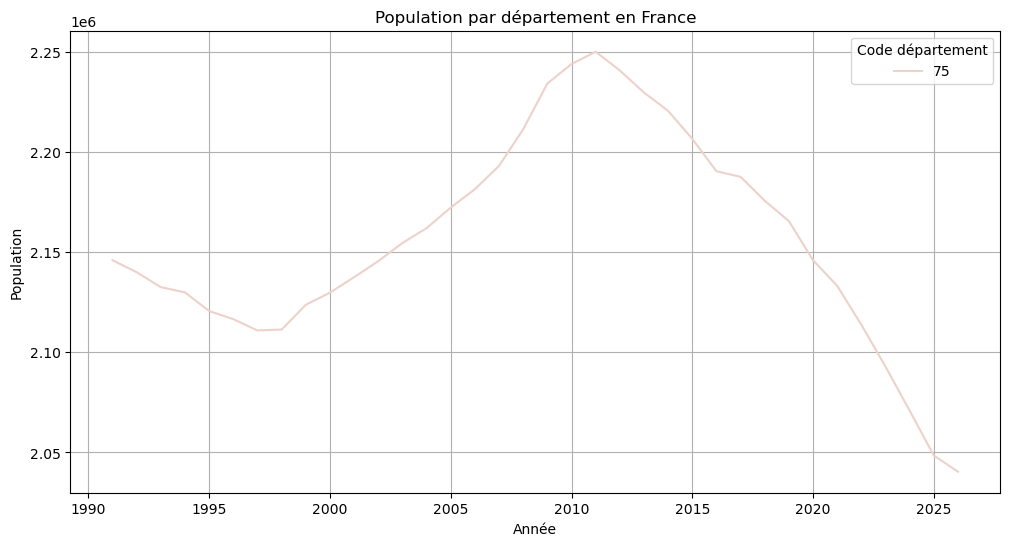

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

df_concatenated_population.loc[df_concatenated_population['code_dep_population'] == 75]

df_paris = df_concatenated_population.loc[df_concatenated_population['code_dep_population'] == 75]

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_paris, x='population_annee', y='population', hue='code_dep_population')
plt.title('Population par d√©partement en France')
plt.xlabel('Ann√©e')
plt.ylabel('Population')
plt.legend(title='Code d√©partement')
plt.grid(True)
plt.show()



In [3]:
import numpy as np
from prophet import Prophet
import pandas as pd
import logging
import os

# Charger le jeu de donn√©es
data_folder = "datasets/datasets_destination/"
df_naissance_france_dep = pd.read_csv(os.path.join(data_folder, "df_naissances_annuelles_france_dep.csv"))

# Pr√©parer le DataFrame
df_ml_naissance_france_dep = df_naissance_france_dep.copy()
df_ml_naissance_france_dep = df_ml_naissance_france_dep.drop(columns=['dimensions.GEO', 'dimensions.EC_MEASURE', 'dimensions.FREQ', 'attributes.OBS_STATUS_FR'])
df_ml_naissance_france_dep['code_dep_naissances'] = df_ml_naissance_france_dep['code_dep_naissances'].apply(lambda x: '201' if x == '2A' else ('202' if x == '2B' else x))
df_ml_naissance_france_dep['code_dep_naissances'] = df_ml_naissance_france_dep['code_dep_naissances'].astype(int)
df_ml_naissance_france_dep = df_ml_naissance_france_dep.sort_values(by=['code_dep_naissances', 'nb_naissances_annee'], ascending=[True, True])

# Ajouter une feature de retard pour capturer la tendance temporelle
df_ml_naissance_france_dep['nb_naissances_t-1'] = df_ml_naissance_france_dep.groupby('code_dep_naissances')['nb_naissances'].shift(1)
df_ml_naissance_france_dep.dropna(inplace=True)

# Configurer le niveau de journalisation pour Prophet
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)
logging.getLogger('prophet').setLevel(logging.ERROR)

# Liste pour stocker les r√©sultats
results = []

# Boucle sur chaque d√©partement
for dept in df_ml_naissance_france_dep['code_dep_naissances'].unique():
    # Filtrer les donn√©es pour le d√©partement courant
    dept_data = df_ml_naissance_france_dep[df_ml_naissance_france_dep['code_dep_naissances'] == dept]

    # V√©rifier si des donn√©es sont pr√©sentes
    if dept_data.empty:
        continue

    # Pr√©parer les donn√©es pour Prophet
    df_prophet = dept_data[['nb_naissances_annee', 'nb_naissances']].rename(columns={'nb_naissances_annee': 'ds', 'nb_naissances': 'y'})
    df_prophet['ds'] = pd.to_datetime(df_prophet['ds'], format='%Y')

    # Initialiser et configurer le mod√®le Prophet
    model = Prophet(
        yearly_seasonality=False,
        seasonality_mode='additive',  # Essayez le mode additif
        changepoint_prior_scale=0.1,  # R√©duisez la sensibilit√© aux changements
        n_changepoints=5  # Augmentez le nombre de points de changement pour plus de flexibilit√©
    )

    model.fit(df_prophet)

    # Cr√©er un DataFrame pour les pr√©dictions futures (2025 et 2026)
    future = model.make_future_dataframe(periods=3, freq='YE')  # 2 ans de pr√©vision

    # Faire des pr√©dictions
    forecast = model.predict(future)

    # Extraire les pr√©dictions pour 2025 et 2026
    for year in [2025, 2026]:
        prediction = forecast.loc[forecast['ds'].dt.year == year, 'yhat'].values
        if len(prediction) > 0:
            results.append({
                'code_dep_naissances': dept,
                'nb_naissances_annee': year,
                'nb_naissances': prediction[0]
            })

# Convertir les r√©sultats en DataFrame
df_results_prophet = pd.DataFrame(results)

# Concat√©ner les DataFrames
df_concatenated_naissance = pd.concat([df_ml_naissance_france_dep, df_results_prophet], axis=0)
df_concatenated_naissance = df_concatenated_naissance.drop(columns=['nb_naissances_t-1'])

# R√©initialiser l'index
df_concatenated_naissance['nb_naissances'] = df_concatenated_naissance['nb_naissances'].astype(int)
df_concatenated_naissance.reset_index(drop=True, inplace=True)


In [4]:
df_concatenated_naissance.loc[df_concatenated_naissance['code_dep_naissances'] == 59]

nb_naissances_annee  nb_naissances  code_dep_naissances
513                  2016          33501                   59
514                  2017          32304                   59
515                  2018          31396                   59
516                  2019          31096                   59
517                  2020          30145                   59
518                  2021          30010                   59
519                  2022          28956                   59
520                  2023          27488                   59
521                  2024          26560                   59
1014                 2025          24126                   59
1015                 2026          22945                   59

In [5]:
df_concatenated_naissance = df_concatenated_naissance.sort_values(by=['code_dep_naissances', 'nb_naissances_annee'], ascending=[True, True])
df_concatenated_population = df_concatenated_population.sort_values(by=['code_dep_population', 'population_annee'], ascending=[True, True])
df_concatenated_naissance.to_csv("datasets/datasets_destination/df_naissances_annuelles_france_dep_ml_prophet_2025_2026.csv", index=False)
df_concatenated_population.to_csv("datasets/datasets_destination/df_population_france_dep_ml_prophet_2025_2026.csv", index=False)

# ML sur donn√©es CAF

In [6]:
import requests
import pandas as pd
import json

def fetch_data_caf(link_dataset, link_label):
    """T√©l√©charge les donn√©es et les labels depuis l'API avec gestion des erreurs."""
    try:
        r_data = requests.get(link_dataset, timeout=10)
        r_data.raise_for_status()
        json_r_data = r_data.json()
        df_data = pd.json_normalize(json_r_data)
    except requests.RequestException as e:
        print(f"Erreur lors de la r√©cup√©ration des donn√©es depuis {link_dataset} : {e}")
        df_data = pd.DataFrame()
    except ValueError as e:
        print(f"Erreur de d√©codage JSON pour {link_dataset} : {e}")
        df_data = pd.DataFrame()

    try:
        r_label = requests.get(link_label, timeout=10)
        r_label.raise_for_status()
        json_r_label = r_label.json()
        df_label = pd.json_normalize(json_r_label, record_path="fields")
    except requests.RequestException as e:
        print(f"Erreur lors de la r√©cup√©ration des labels depuis {link_label} : {e}")
        df_label = pd.DataFrame()
    except ValueError as e:
        print(f"Erreur de d√©codage JSON pour {link_label} : {e}")
        df_label = pd.DataFrame()

    return df_data, df_label

def convert_to_quarter_chomage(date_str):
    year, month = map(int, date_str.split('-'))
    quarter = (month - 1) // 3 + 1
    year = year - 2
    return f"T{quarter}_{year}"

def convert_to_year_population(date_str):
    year, month = map(int, date_str.split('-'))
    year = year
    return f"{year}"


df_s_ben_dep_data, df_s_ben_dep_label = fetch_data_caf(
    "https://data.caf.fr/api/explore/v2.1/catalog/datasets/s_ben_dep/exports/json",
    "https://data.caf.fr/api/explore/v2.1/catalog/datasets/s_ben_dep"
)

df_s_ben_dep_data["trimestre_chomage"] = df_s_ben_dep_data["dtreffre"].apply(convert_to_quarter_chomage).copy()
df_s_ben_dep_data["annee_population"] = df_s_ben_dep_data["dtreffre"].apply(convert_to_year_population).copy()

departement_drop = ['99', '978', '976', 'XX']
df_s_ben_dep_data = df_s_ben_dep_data.loc[~df_s_ben_dep_data['numdep'].isin(departement_drop)].copy()

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import re
import os

data_folder = "datasets/datasets_destination/"

# Charger les datasets
chomage_df = pd.read_csv(f'{data_folder}/df_chomage_BIT_france_dep.csv')
naissances_df = pd.read_csv(f'{data_folder}/df_naissances_annuelles_france_dep_ml_prophet_2025_2026.csv')
population_df = pd.read_csv(f'{data_folder}/df_population_france_dep_ml_prophet_2025_2026.csv')

df_s_ben_dep_data['numdep'] = df_s_ben_dep_data['numdep'].apply(lambda x: '201' if x == '2A' else ('202' if x == '2B' else x))
chomage_df['Code'] = chomage_df['REF_AREA'].apply(lambda x: re.search(r'D(.*)', x).group(1))
chomage_df['Trimestre'] = chomage_df['TIME_PERIOD'].str.replace('-Q', '-T')
chomage_df['Trimestre'] = chomage_df['Trimestre'].apply(lambda x: f"{x.split('-')[1]}_{x.split('-')[0]}")
chomage_df['Code'] = chomage_df['Code'].apply(lambda x: '201' if x == '2A' else ('202' if x == '2B' else x))

df_s_ben_dep_data["trimestre_chomage"] = df_s_ben_dep_data["trimestre_chomage"].astype(str)
df_s_ben_dep_data["annee_population"] = df_s_ben_dep_data["annee_population"].astype(int)
df_s_ben_dep_data["numdep"] = df_s_ben_dep_data["numdep"].astype(int)
chomage_df["Code"] = chomage_df["Code"].astype(int)
population_df["population_annee"] = population_df["population_annee"].astype(int)
population_df["code_dep_population"] = population_df["code_dep_population"].astype(int)
population_df["population"] = population_df["population"].astype(int)
naissances_df["nb_naissances_annee"] = naissances_df["nb_naissances_annee"].astype(int)
naissances_df["code_dep_naissances"] = naissances_df["code_dep_naissances"].astype(int)
naissances_df["nb_naissances"] = naissances_df["nb_naissances"].astype(int)

df_s_ben_dep_data = df_s_ben_dep_data.merge(chomage_df[['Code','Trimestre','OBS_VALUE']], 
                            left_on=["trimestre_chomage", "numdep"],
                            right_on=["Trimestre", "Code"],
                            how="left")

df_s_ben_dep_data = df_s_ben_dep_data.merge(population_df[['code_dep_population','population','population_annee']],
                                                    left_on=["annee_population", "numdep"],
                                                    right_on=["population_annee", "code_dep_population"],
                                                    how="left")

df_s_ben_dep_data = df_s_ben_dep_data.merge(naissances_df[['code_dep_naissances','nb_naissances','nb_naissances_annee']],
                                                    left_on=["annee_population", "numdep"],
                                                    right_on=["nb_naissances_annee", "code_dep_naissances"],
                                                    how="left")

df_s_ben_dep_data = df_s_ben_dep_data.rename(columns={"OBS_VALUE": "taux_chomage"})
df_s_ben_dep_data['taux_chomage'] = df_s_ben_dep_data['taux_chomage'].astype(float)
df_s_ben_dep_data['population'] = df_s_ben_dep_data['population'].astype(float)
df_s_ben_dep_data['nb_naissances'] = df_s_ben_dep_data['nb_naissances'].astype(float)
df_s_ben_dep_data = df_s_ben_dep_data.drop(columns=['Code','annee_population','Trimestre',
                                                            'code_dep_naissances','nb_naissances_annee',
                                                            'code_dep_population','population_annee'])

df_s_ben_dep_data["dtreffre"] = pd.to_datetime(df_s_ben_dep_data["dtreffre"])
df_s_ben_dep_data["year"] = df_s_ben_dep_data["dtreffre"].dt.year
df_s_ben_dep_data["month"] = df_s_ben_dep_data["dtreffre"].dt.month


In [8]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

df_column_to_keep = ['numdep','indmtt_ndur','taux_chomage','population','nb_naissances','year','month']

df_ml_ben_dep_data = df_s_ben_dep_data.copy()
df_ml_ben_dep_data = df_ml_ben_dep_data.select_dtypes(include="number")
df_ml_ben_dep_data = df_ml_ben_dep_data[df_column_to_keep].copy()

X = df_ml_ben_dep_data.drop(columns=["indmtt_ndur"])
y = df_ml_ben_dep_data["indmtt_ndur"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest Model with the best parameters found
rf_best = RandomForestRegressor(
    n_estimators=250,
    max_depth=20,
    min_samples_split=20,
    min_samples_leaf=4,
    bootstrap=True,
    random_state=42
)

# Fit the model
rf_best.fit(X_train, y_train)

# Predict
y_pred_train_rf = rf_best.predict(X_train)
y_pred_test_rf = rf_best.predict(X_test)

# Calculate metrics for Random Forest
def calculate_metrics(y_train, y_pred_train, y_test, y_pred_test):
    mae_train = mean_absolute_error(y_train, y_pred_train)
    rmse_train = mean_squared_error(y_train, y_pred_train) ** 0.5
    r2_train = r2_score(y_train, y_pred_train)
    
    mae_test = mean_absolute_error(y_test, y_pred_test)
    rmse_test = mean_squared_error(y_test, y_pred_test) ** 0.5
    r2_test = r2_score(y_test, y_pred_test)

    return mae_train, rmse_train, r2_train, mae_test, rmse_test, r2_test

# Metrics for Random Forest (best model)
mae_train_rf, rmse_train_rf, r2_train_rf, mae_test_rf, rmse_test_rf, r2_test_rf = calculate_metrics(y_train, y_pred_train_rf, y_test, y_pred_test_rf)

# Print results for Random Forest
print("Random Forest Model (with best parameters):")
print(f"Train - MAE: {mae_train_rf}, RMSE: {rmse_train_rf}, R2: {r2_train_rf}")
print(f"Test - MAE: {mae_test_rf}, RMSE: {rmse_test_rf}, R2: {r2_test_rf}")



Random Forest Model (with best parameters):
Train - MAE: 1039910.684635422, RMSE: 9136841.256093556, R2: 0.9695227751697924
Test - MAE: 1170393.2670983467, RMSE: 3876280.4826144855, R2: 0.9941746881176274


In [9]:
import joblib

# Sauvegarder le mod√®le
joblib.dump(rf_best, "random_forest_model.pkl")
print("Mod√®le sauvegard√© sous 'random_forest_model.pkl'")

# Export de df_s_ben_dep_data vers df_s_ben_dep_data_ml.csv
df_s_ben_dep_data.to_csv("datasets/datasets_destination/df_s_ben_dep_data_ml.csv", index=False)

Mod√®le sauvegard√© sous 'random_forest_model.pkl'


In [ ]:
# import pandas as pd
# from prophet import Prophet
# import joblib
# import os

# # Cr√©ation du dossier de sauvegarde s'il n'existe pas
# output_dir = "ml_prophet"
# os.makedirs(output_dir, exist_ok=True)

# # Chargement du DataFrame depuis le CSV d√©partemental
# df = pd.read_csv("datasets/datasets_destination/df_s_ben_dep_data_ml.csv")
# print("Colonnes du dataframe :", df.columns.tolist())

# # V√©rifier la pr√©sence de la colonne d'identification des d√©partements
# if 'numdep' not in df.columns:
#     raise KeyError("La colonne d'identification des d√©partements ('numdep') est introuvable dans le dataframe.")

# # Cr√©ation de la colonne 'ds' attendue par Prophet √† partir de 'year' et 'month'
# df['ds'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month'].astype(str).str.zfill(2) + '-01')

# # Renommage de la colonne cible en 'y'
# if 'indmtt_ndur' in df.columns:
#     df.rename(columns={'indmtt_ndur': 'y'}, inplace=True)
# else:
#     raise KeyError("La colonne cible 'indmtt_ndur' est introuvable dans le dataframe.")

# print("Colonnes apr√®s transformation :", df.columns.tolist())
# print(df.head())

# # Dictionnaire pour stocker les mod√®les par d√©partement
# models = {}

# # Extraction des codes d√©partementaux uniques
# departements = df['numdep'].unique()

# # Entra√Ænement d'un mod√®le Prophet pour chaque d√©partement
# for dep in departements:
#     df_dep = df[df['numdep'] == dep].copy()
#     df_dep = df_dep.sort_values('ds')
    
#     # Instanciation du mod√®le Prophet avec des param√®tres adapt√©s
#     model = Prophet(
#         growth='linear',
#         changepoint_prior_scale=0.01,  # Tendance presque plate
#         seasonality_mode='additive',
#         yearly_seasonality=False,        # Pour capter les oscillations annuelles
#         weekly_seasonality=False,
#         daily_seasonality=False,
#     )
    
#     # Ajout des r√©gressions suppl√©mentaires si pr√©sentes
#     for reg in ['taux_chomage', 'population', 'nb_naissances']:
#         if reg in df_dep.columns:
#             model.add_regressor(reg)
#         else:
#             print(f"Attention : la colonne '{reg}' n'est pas pr√©sente pour le d√©partement {dep}.")
    
#     print(f"Entra√Ænement du mod√®le Prophet pour le d√©partement {dep} en cours...")
#     model.fit(df_dep)
#     models[dep] = model
    
#     # Formatage du code d√©partemental pour avoir deux chiffres (0 devant si n√©cessaire)
#     dep_str = str(dep).zfill(2)
#     file_path = os.path.join(output_dir, f"prophet_model_{dep_str}.pkl")
#     joblib.dump(model, file_path)
#     print(f"Mod√®le pour le d√©partement {dep} sauvegard√© sous '{file_path}'.")


Colonnes du dataframe : ['dtreffre', 'numdep', 'nomdep', 'numregi', 'nomregi', 'indfoy_ndur', 'indnbp_ndur', 'indmtt_ndur', 'indfoy_ndurpaje', 'indnbp_ndurpaje', 'indmtt_ndurpaje', 'indfoy_pn', 'indnbp_pn', 'indmtt_pn', 'indfoy_ab', 'indnbp_ab', 'indmtt_ab', 'indfoy_cmg', 'indnbp_cmg', 'indmtt_cmg', 'indfoy_prepare', 'indnbp_prepare', 'indmtt_prepare', 'indfoy_ndurej', 'indnbp_ndurej', 'indmtt_ndurej', 'indfoy_af', 'indnbp_af', 'indmtt_af', 'indfoy_cf', 'indnbp_cf', 'indmtt_cf', 'indfoy_ars', 'indnbp_ars', 'indmtt_ars', 'indfoy_asf', 'indnbp_asf', 'indmtt_asf', 'indfoy_ndurhd', 'indnbp_ndurhd', 'indmtt_ndurhd', 'indfoy_aah', 'indben_aah', 'indnbp_aah', 'indmtt_aah', 'indfoy_aeeh', 'indben_aeeh', 'indnbp_aeeh', 'indmtt_aeeh', 'indfoy_ajpa', 'indben_ajpa', 'indnbp_ajpa', 'indmtt_ajpa', 'indfoy_ajpp', 'indben_ajpp', 'indnbp_ajpp', 'indmtt_ajpp', 'indfoy_ndural', 'indnbp_ndural', 'indmtt_ndural', 'indfoy_alf', 'indnbp_alf', 'indmtt_alf', 'indfoy_als', 'indnbp_als', 'indmtt_als', 'indfoy_ap

In [11]:
import pandas as pd
from prophet import Prophet
import joblib
import os

# Liste des colonnes cibles √† mod√©liser
target_columns = ['indmtt_ndur', 'indmtt_ndurpaje', 'indmtt_pn', 'indmtt_ndurej']

# Chargement du DataFrame
df = pd.read_csv("datasets/datasets_destination/df_s_ben_dep_data_ml.csv")
print("Colonnes du dataframe :", df.columns.tolist())

# V√©rification de la colonne 'numdep'
if 'numdep' not in df.columns:
    raise KeyError("La colonne 'numdep' est requise mais introuvable.")

# Cr√©ation de la colonne 'ds' attendue par Prophet
df['ds'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month'].astype(str).str.zfill(2) + '-01')

# Extraction des d√©partements
departements = df['numdep'].unique()

# Boucle sur les colonnes cibles
for target in target_columns:
    if target not in df.columns:
        print(f"‚ö†Ô∏è  Colonne cible '{target}' absente, mod√®le non g√©n√©r√©.")
        continue

    print(f"\n### Traitement de la target : {target} ###")
    
    # Cr√©ation d‚Äôun dossier de sortie sp√©cifique √† la target
    output_dir = os.path.join("ml_prophet", target)
    os.makedirs(output_dir, exist_ok=True)
    
    # Boucle sur les d√©partements
    for dep in departements:
        df_dep = df[df['numdep'] == dep].copy()
        df_dep = df_dep.sort_values('ds')
        
        df_dep = df_dep.rename(columns={target: 'y'})
        
        # Si la target est enti√®rement nulle ou NaN, on passe
        if df_dep['y'].isna().all() or df_dep['y'].sum() == 0:
            print(f"‚ùå Donn√©es insuffisantes pour le d√©partement {dep} - target {target}")
            continue
        
        model = Prophet(
            growth='linear',
            changepoint_prior_scale=0.01,
            seasonality_mode='additive',
            yearly_seasonality=False,
            weekly_seasonality=False,
            daily_seasonality=False,
        )
        
        for reg in ['taux_chomage', 'population', 'nb_naissances']:
            if reg in df_dep.columns:
                model.add_regressor(reg)
            else:
                print(f"‚ö†Ô∏è  '{reg}' absent dans les donn√©es du d√©partement {dep}.")
        
        print(f"üîß Entra√Ænement du mod√®le pour {target} - D√©partement {dep}...")
        model.fit(df_dep)
        
        # Sauvegarde du mod√®le
        dep_str = str(dep).zfill(2)
        file_path = os.path.join(output_dir, f"prophet_model_{dep_str}.pkl")
        joblib.dump(model, file_path)
        print(f"‚úÖ Mod√®le sauvegard√© : {file_path}")


Colonnes du dataframe : ['dtreffre', 'numdep', 'nomdep', 'numregi', 'nomregi', 'indfoy_ndur', 'indnbp_ndur', 'indmtt_ndur', 'indfoy_ndurpaje', 'indnbp_ndurpaje', 'indmtt_ndurpaje', 'indfoy_pn', 'indnbp_pn', 'indmtt_pn', 'indfoy_ab', 'indnbp_ab', 'indmtt_ab', 'indfoy_cmg', 'indnbp_cmg', 'indmtt_cmg', 'indfoy_prepare', 'indnbp_prepare', 'indmtt_prepare', 'indfoy_ndurej', 'indnbp_ndurej', 'indmtt_ndurej', 'indfoy_af', 'indnbp_af', 'indmtt_af', 'indfoy_cf', 'indnbp_cf', 'indmtt_cf', 'indfoy_ars', 'indnbp_ars', 'indmtt_ars', 'indfoy_asf', 'indnbp_asf', 'indmtt_asf', 'indfoy_ndurhd', 'indnbp_ndurhd', 'indmtt_ndurhd', 'indfoy_aah', 'indben_aah', 'indnbp_aah', 'indmtt_aah', 'indfoy_aeeh', 'indben_aeeh', 'indnbp_aeeh', 'indmtt_aeeh', 'indfoy_ajpa', 'indben_ajpa', 'indnbp_ajpa', 'indmtt_ajpa', 'indfoy_ajpp', 'indben_ajpp', 'indnbp_ajpp', 'indmtt_ajpp', 'indfoy_ndural', 'indnbp_ndural', 'indmtt_ndural', 'indfoy_alf', 'indnbp_alf', 'indmtt_alf', 'indfoy_als', 'indnbp_als', 'indmtt_als', 'indfoy_ap